<h1><center>Pattern Recognition using problem Solving CA1</center><h1>

<h2><center>Model Testing</center><h2>

In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plot matplotlib graph
%matplotlib inline

#=========================================================================
# Next, we will import the required modules. Then we will define a generic 
# classification function, which takes a model as input and determines the 
# Accuracy and Cross-Validation scores.
#=========================================================================

#Import models from scikit learn module:
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pickle
from sklearn.externals import joblib

#=========================================================================
# Read train data using pandas and first 5 rows of data
#=========================================================================

xls1    = pd.ExcelFile('X_train_scaled_SL.xlsx')
X_train = pd.read_excel(xls1, 'X_train_scaled')
y_train = pd.read_excel(xls1, 'y_train')

xls2    = pd.ExcelFile('X_test_scaled_SL.xlsx')
X_test  = pd.read_excel(xls2, 'X_test_scaled')
y_test  = pd.read_excel(xls2, 'y_test')

Drop_col =['waterpoint_type_9:Unprotected dug well','waterpoint_type_OTHER','extraction_type_3:Surface pump',
           'extraction_type_2:Submersible pump','extraction_type_OTHER','waterpoint_type_3:Tube well or borehole',
           'waterpoint_type_2:Protected dug well','extraction_type_4:Hydram pump','extraction_type_5:Gravity',
           'extraction_type_1:Hand pump','waterpoint_type_5:Sand/Sub-surface dam (with well or standpipe)']

X_train = X_train.drop(Drop_col,axis=1)

X_test  = X_test.drop(Drop_col,axis=1)

dataset = X_train
dataset['water point functionality'] = y_train['water point functionality']

X_train = X_train.drop(['water point functionality'],axis=1)
X_train.head()

C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


,latitude,longitude,broke_down_repair,owns_water_point,management_committee,Pump_Age,"extraction_type_7:Hand manual (e.g. rope pump, rope & bucket)",waterpoint_type_6:Public tap/standpipe (stand-alone or water kiosk
0,-0.932172,0.966087,1.555556,-0.888534,2.069598,0.021109,-0.60559,2.164179
1,1.427505,0.681034,0.995433,-0.888534,2.069598,2.528743,-0.60559,2.164179
2,-1.409157,-0.810818,-1.245061,1.332702,-1.127092,-0.767004,-0.60559,-0.462069
3,-1.468861,-0.779851,0.435309,1.332702,-1.127092,-0.767004,-0.60559,-0.462069
4,0.269463,-1.711111,-0.124814,-0.888534,2.069598,-0.337124,-0.60559,2.164179


<h3>Define Functions<h3>

In [3]:
#Generic function for making a classification model and accessing performance:

def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [4]:
#-----------------------------------------------------------------
# Function for Random Decision Tree, Decision Tree CLassifier, 
# Random Forest Classifier and Gradient Boosting CLassifier
#-----------------------------------------------------------------
def classification_model_Test(model, X_train, y_train, X_test, y_test):
  #Fit the model:
  
  model.fit(X_train,y_train)

  print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
  print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))  
    
  #Make predictions on training set:
  predictions = model.predict(X_test)
     
  # Get performance metrics
  cm = confusion_matrix(y_test,predictions)
  print(metrics.classification_report(y_test,predictions))
  score = compute_score(clf=model, X=X_test, y=y_test, scoring='accuracy')
  r2_score = metrics.r2_score(y_test,predictions)
  
  # Print performance metrics

  print ('*************************************************************')
  print ('Metric Performance of : {0}\n'.format(model.__class__))
  print('Confusion Matrix : \n', cm)
  print ('Cross Validation Score = {0:.3%}\n'.format(score))
  print ("Coefficient of determination:{0:.3f}".format(r2_score))
   
  #Fit the model again so that it can be refered outside the function:
  model.fit(X_train,y_train) 

In [5]:
#-----------------------------------------------------------------
# Function for Validation data testing
#-----------------------------------------------------------------
def classification_model_Val(model, X_val, y_val):
  
  print("Accuracy on training set: {:.3f}".format(model.score(X_val, y_val)))
  #Make predictions on training set:
  predictions = model.predict(X_val)
     
  # Get performance metrics
  cm = confusion_matrix(y_val,predictions)
  print(metrics.classification_report(y_val,predictions))
  score = compute_score(clf=model, X=X_val, y=y_val, scoring='accuracy')
  r2_score = metrics.r2_score(y_val,predictions)
  
  # Print performance metrics

  print ('*************************************************************')
  print ('Metric Performance of : {0}\n'.format(model.__class__))
  print('Confusion Matrix : \n', cm)
  print ('Cross Validation Score = {0:.3%}\n'.format(score))
  print ("Coefficient of determination:{0:.3f}".format(r2_score))


In [6]:
# Checking on the feature importance weightage
from sklearn.metrics import confusion_matrix

def features_importance(clf, data, predictors, outcome):
    target = data[outcome]
    train = data[predictors]

    clf = clf.fit(train,target)
    
    features = pd.DataFrame()
    features['feature'] = train.columns
    features['importance'] = clf.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    print ('*************************************************************')
    features.plot(title = 'Features Importance',fontsize= 8, kind='barh', figsize=(50, 10))
    featimp = pd.Series(clf.feature_importances_, index=predictors).sort_values(ascending=False)
    print (featimp)
    print('\n**********************************************************')

<h2><center>Create Model and test</center><h2>

In [7]:
outcome_var = 'water point functionality'
predictor_var = X_train.columns

In [8]:
outcome_var

'water point functionality'

In [9]:
predictor_var

Index(['latitude', 'longitude', 'broke_down_repair', 'owns_water_point',
       'management_committee', 'Pump_Age',
       'extraction_type_7:Hand manual (e.g. rope pump, rope & bucket)',
       'waterpoint_type_6:Public tap/standpipe (stand-alone or water kiosk'],
      dtype='object')

In [10]:
X_train.count()

latitude                                                              14374
longitude                                                             14374
broke_down_repair                                                     14374
owns_water_point                                                      14374
management_committee                                                  14374
Pump_Age                                                              14374
extraction_type_7:Hand manual (e.g. rope pump, rope & bucket)         14374
waterpoint_type_6:Public tap/standpipe (stand-alone or water kiosk    14374
dtype: int64

In [11]:
X_test.count()

latitude                                                              4493
longitude                                                             4493
broke_down_repair                                                     4493
owns_water_point                                                      4493
management_committee                                                  4493
Pump_Age                                                              4493
extraction_type_7:Hand manual (e.g. rope pump, rope & bucket)         4493
waterpoint_type_6:Public tap/standpipe (stand-alone or water kiosk    4493
dtype: int64

<h3>Random Forest Classifier<h3>

In [12]:
param_grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,8,9,10,15,20],
    'criterion' :['gini', 'entropy']
}

In [13]:
model = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv= 5,n_jobs=-1)
classification_model_Test(model, X_train, y_train, X_test, y_test)

C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Accuracy on training set: 0.904
Accuracy on test set: 0.787
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3103
           1       0.38      0.06      0.10       190
           2       0.51      0.15      0.23       285
           3       0.65      0.62      0.64       915

    accuracy                           0.79      4493
   macro avg       0.59      0.44      0.46      4493
weighted avg       0.75      0.79      0.76      4493



C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_s

*************************************************************
Metric Performance of : <class 'sklearn.model_selection._search.GridSearchCV'>

Confusion Matrix : 
 [[2912    9   17  165]
 [ 139   11    1   39]
 [ 140    2   43  100]
 [ 316    7   23  569]]
Cross Validation Score = 76.808%

Coefficient of determination:0.207


C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [14]:
model.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 200}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy on training set: 0.902
Accuracy on test set: 0.788
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3103
           1       0.41      0.06      0.11       190
           2       0.55      0.16      0.25       285
           3       0.65      0.62      0.63       915

    accuracy                           0.79      4493
   macro avg       0.61      0.45      0.47      4493
weighted avg       0.76      0.79      0.76      4493



C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Wilson\AppData\Roaming\Python\Python37\site-packages\sklearn\mod

*************************************************************
Metric Performance of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>

Confusion Matrix : 
 [[2918    8   15  162]
 [ 135   12    1   42]
 [ 140    2   46   97]
 [ 322    7   22  564]]
Cross Validation Score = 76.742%

Coefficient of determination:0.204


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


*************************************************************
broke_down_repair                                                     0.287580
latitude                                                              0.210565
longitude                                                             0.206960
Pump_Age                                                              0.133206
owns_water_point                                                      0.081604
management_committee                                                  0.032859
extraction_type_7:Hand manual (e.g. rope pump, rope & bucket)         0.029933
waterpoint_type_6:Public tap/standpipe (stand-alone or water kiosk    0.017294
dtype: float64

**********************************************************


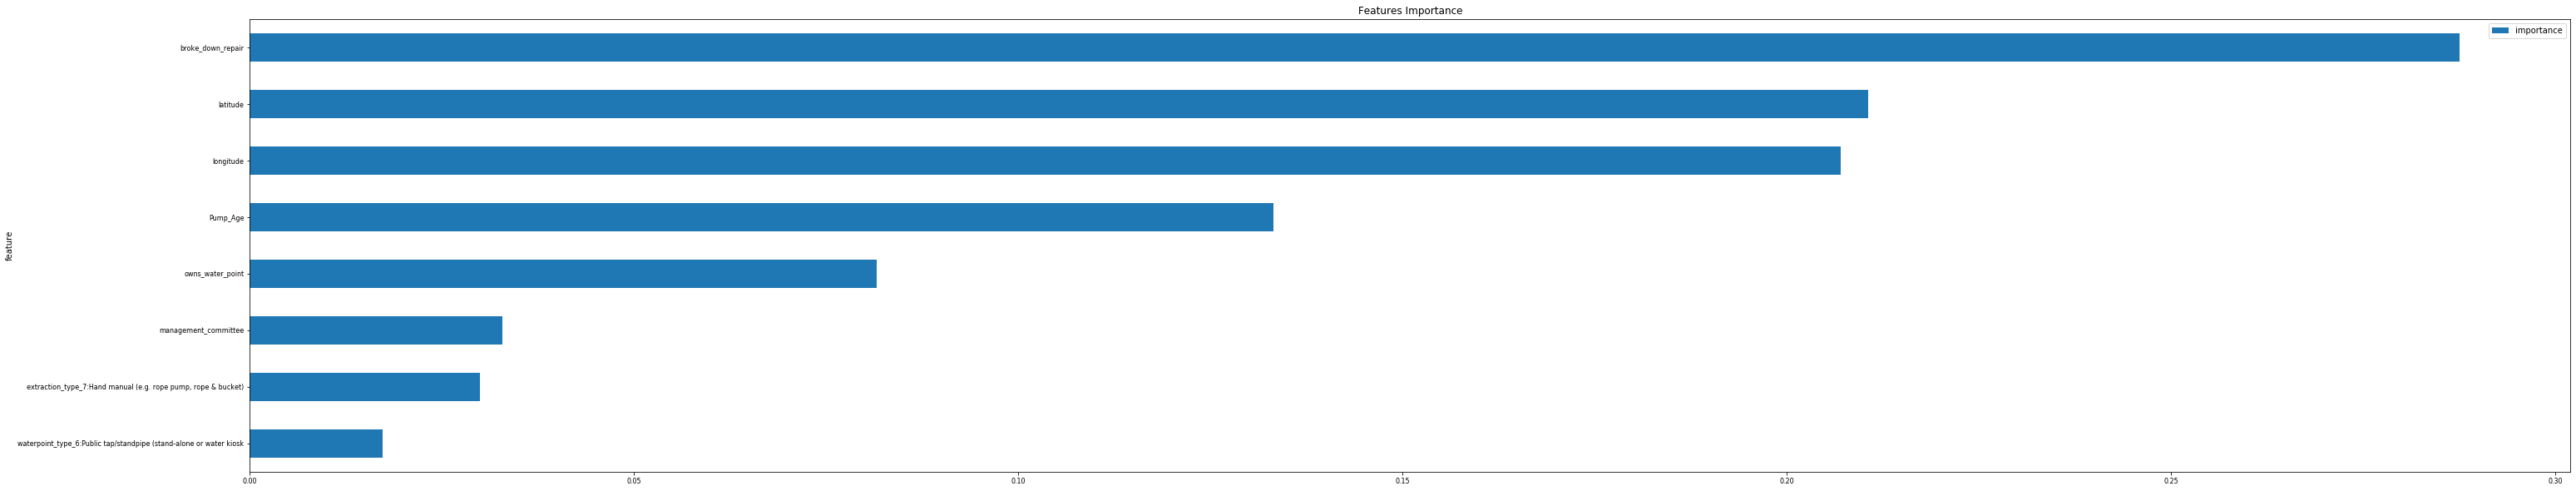

In [15]:

model = RandomForestClassifier(criterion = 'gini',max_depth = 15,max_features = 'sqrt', n_estimators = 300)

classification_model_Test(model, X_train, y_train, X_test, y_test)
features_importance(model, dataset,predictor_var,outcome_var)
 

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0371017 to fit


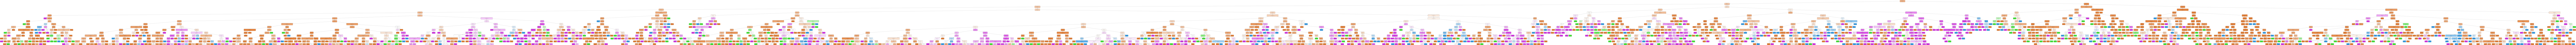

In [15]:
estimator_limited = model.estimators_[7]
export_graphviz(estimator_limited, out_file='Random_Forest_limited_to_5.dot', feature_names = predictor_var,
                class_names = outcome_var,
                rounded = True, proportion = False, precision = 2, filled = True)

!dot -Tpng Random_Forest_limited_to_5.dot -o Random_Forest_limited_to_5.png -Gdpi=600
from IPython.display import Image
Image(filename = 'Random_Forest_limited_to_5.png')

In [16]:
## We can save the trained model clf using pickle 
s = pickle.dumps(model)
pickle.dump( model, open( "Random_Forest_trained_model_20F_SL.p", "wb" ) )

# Alternatively, we can save the trained model clf with sklearn joblib
joblib.dump(model, 'Random_Forest_trained_model_20F_SL.pkl') 


['Random_Forest_trained_model_20F_SL.pkl']

<h3>Gradient Boosting Classifier<h3>

In [ ]:
param_grid = {
#    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#    "min_samples_split": np.linspace(0.1, 0.5, 12),
#    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[5,8,10,15,20],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
#    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[200,300,400,500]
}

In [ ]:
param_grid = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

In [ ]:
model = GridSearchCV(estimator =GradientBoostingClassifier( random_state=10), 
            param_grid = param_grid, scoring='accuracy',iid=False, cv=5,n_jobs=-1)

In [ ]:
model.grid_scores_, model.best_score_

In [ ]:
model.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on training set: 1.000
Accuracy on test set: 0.778
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3103
           1       0.38      0.15      0.22       190
           2       0.48      0.22      0.30       285
           3       0.62      0.61      0.62       915

   micro avg       0.78      0.78      0.78      4493
   macro avg       0.58      0.47      0.50      4493
weighted avg       0.75      0.78      0.76      4493



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

*************************************************************
Metric Performance of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>

Confusion Matrix : 
 [[2843   21   26  213]
 [ 118   29    4   39]
 [ 124    7   62   92]
 [ 299   19   36  561]]
Cross Validation Score = 75.629%

Coefficient of determination:0.163


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************
latitude                                                              0.257893
longitude                                                             0.257649
broke_down_repair                                                     0.224701
Pump_Age                                                              0.129531
owns_water_point                                                      0.064754
management_committee                                                  0.027132
extraction_type_7:Hand manual (e.g. rope pump, rope & bucket)         0.024797
waterpoint_type_6:Public tap/standpipe (stand-alone or water kiosk    0.013542
dtype: float64

**********************************************************


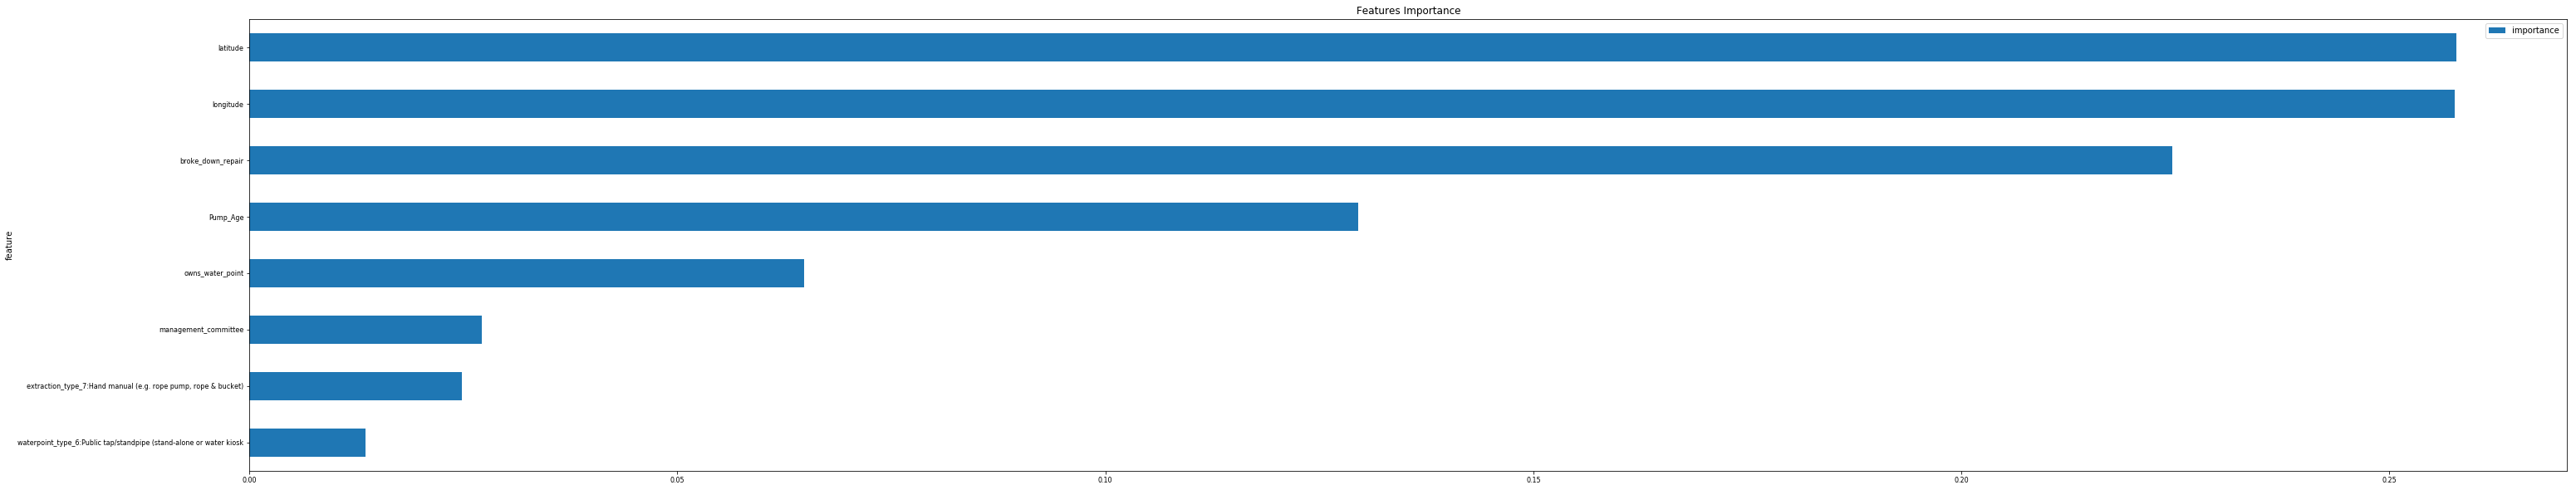

In [18]:
model = GradientBoostingClassifier(max_depth=15,n_estimators = 300,max_features = 'sqrt',
                                   random_state=8,learning_rate=0.1)

classification_model_Test(model, X_train, y_train, X_test, y_test)
features_importance(model, dataset,predictor_var,outcome_var)

In [19]:
# We can save the trained model clf using pickle 
s = pickle.dumps(model)
pickle.dump( model, open( "Gradient_Boosting_Classifier_trained_model_20F_SL.p", "wb" ) )

# Alternatively, we can save the trained model clf with sklearn joblib
joblib.dump(model, 'Gradient_Boosting_Classifier_trained_model_20F_SL.pkl') 

['Gradient_Boosting_Classifier_trained_model_20F_SL.pkl']

<h3>K Nearest Neigbors KNN Model<h3>

In [20]:
model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='distance')
classification_model_Test(model, X_train, y_train, X_test, y_test)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Accuracy on training set: 1.000
Accuracy on test set: 0.776
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3103
           1       0.40      0.11      0.17       190
           2       0.46      0.18      0.25       285
           3       0.62      0.62      0.62       915

   micro avg       0.78      0.78      0.78      4493
   macro avg       0.58      0.46      0.48      4493
weighted avg       0.75      0.78      0.75      4493

*************************************************************
Metric Performance of : <class 'sklearn.neighbors.classification.KNeighborsClassifier'>

Confusion Matrix : 
 [[2847   16   29  211]
 [ 126   21    1   42]
 [ 138    3   50   94]
 [ 305   13   29  568]]
Cross Validation Score = 75.117%

Coefficient of determination:0.151


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y

In [21]:
# We can save the trained model clf using pickle 
s = pickle.dumps(model)
pickle.dump( model, open( "KNN_trained_model_20F_SL.p", "wb" ) )

# Alternatively, we can save the trained model clf with sklearn joblib
joblib.dump(model, 'KNN_trained_model_20F_SL.pkl') 

['KNN_trained_model_20F_SL.pkl']

In [ ]:
Grid_params = {
    'n_neighbors':[3,5,11,19,22,25,28,30],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

model = GridSearchCV(
    KNeighborsClassifier(),
    Grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

classification_model_Test(model, X_train, y_train, X_test, y_test)

In [ ]:
model.best_score_

In [ ]:
model.best_estimator_

In [ ]:
model.best_params_

In [ ]:
 #We can save the trained model clf using pickle 
s = pickle.dumps(model)
pickle.dump( model, open( "KNN_trained_model_20F_SL.p", "wb" ) )

# Alternatively, we can save the trained model clf with sklearn joblib
joblib.dump(model, 'KNN_trained_model_SL_20F.pkl') 

<h3>Support Vector Machine Model<h3>

In [22]:
model = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovo', degree=3, gamma=2, kernel='rbf',
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)
classification_model_Test(model, X_train, y_train, X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on training set: 0.811
Accuracy on test set: 0.768
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      3103
           1       0.40      0.03      0.06       190
           2       0.60      0.11      0.18       285
           3       0.62      0.55      0.59       915

   micro avg       0.77      0.77      0.77      4493
   macro avg       0.61      0.41      0.42      4493
weighted avg       0.74      0.77      0.73      4493



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

*************************************************************
Metric Performance of : <class 'sklearn.svm.classes.SVC'>

Confusion Matrix : 
 [[2909    3    8  183]
 [ 149    6    1   34]
 [ 165    2   30   88]
 [ 393    4   11  507]]
Cross Validation Score = 74.316%

Coefficient of determination:0.080


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
# We can save the trained model clf using pickle 
s = pickle.dumps(model)
pickle.dump( model, open( "SVM_trained_model_20F_SL.p", "wb" ) )

# Alternatively, we can save the trained model clf with sklearn joblib
joblib.dump(model, 'SVM_trained_model_20F_SL.pkl') 

['SVM_trained_model_20F_SL.pkl']

In [ ]:
svm = SVC()
parameters = {'C':(1,0.25,0.5,0.75),'gamma': (1,2,3,'auto'),
              'decision_function_shape':('ovo','ovr'),'shrinking':(True,False)}
model = GridSearchCV(svm, parameters)

classification_model_Test(model, X_train, y_train, X_test, y_test)

In [ ]:
model.best_estimator_

In [ ]:
model.best_params_

In [ ]:
# We can save the trained model clf using pickle 
s = pickle.dumps(model)
pickle.dump( model, open( "SVM_trained_model_20F_SL.p", "wb" ) )

# Alternatively, we can save the trained model clf with sklearn joblib
joblib.dump(model, 'SVM_trained_model_20F_SL.pkl')

<h3> X Validation set <h3>

In [24]:
xls3    = pd.ExcelFile('X_val_scaled_SL.xlsx')
X_val = pd.read_excel(xls3, 'X_val_scaled')
y_val = pd.read_excel(xls3, 'y_val')

X_val  = X_val.drop(Drop_col,axis=1)

dataset_test = X_val
dataset_test['water point functionality'] = y_val['water point functionality']

X_val = X_val.drop(['water point functionality'],axis=1)

In [25]:
outcome_var = 'water point functionality'
predictor_var = y_val.columns

In [26]:
dataset_test.head()

,latitude,longitude,broke_down_repair,owns_water_point,management_committee,Pump_Age,"extraction_type_7:Hand manual (e.g. rope pump, rope & bucket)",waterpoint_type_6:Public tap/standpipe (stand-alone or water kiosk,water point functionality
0,0.753139,1.333992,-1.245061,-0.888534,0.471253,1.167456,-0.605590,-0.462069,0
1,-0.738590,0.938583,-0.684937,1.332702,0.471253,-0.122184,-0.605590,2.164179,2
2,-0.619297,0.238721,0.435309,1.332702,2.069598,1.454043,1.651282,-0.462069,0
3,0.756218,-1.105769,-0.684937,1.015382,0.471253,0.307696,-0.605590,-0.462069,0
4,-0.617318,0.263184,-1.245061,1.332702,0.471253,-0.695358,1.651282,-0.462069,0


In [27]:
X_val.count()

latitude                                                              3594
longitude                                                             3594
broke_down_repair                                                     3594
owns_water_point                                                      3594
management_committee                                                  3594
Pump_Age                                                              3594
extraction_type_7:Hand manual (e.g. rope pump, rope & bucket)         3594
waterpoint_type_6:Public tap/standpipe (stand-alone or water kiosk    3594
dtype: int64

In [28]:
y_val.count()

water point functionality    3594
dtype: int64

<h3>Random Forest Classifier<h3>

In [29]:
# Load the classifier model
model = pickle.load( open( "Random_Forest_trained_model_20F_SL.p", "rb" ) )

In [30]:
classification_model_Val(model, X_val, y_val)

Accuracy on training set: 0.770
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2461
           1       0.55      0.07      0.13       166
           2       0.56      0.17      0.26       254
           3       0.61      0.60      0.61       713

   micro avg       0.77      0.77      0.77      3594
   macro avg       0.63      0.44      0.47      3594
weighted avg       0.75      0.77      0.74      3594



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

*************************************************************
Metric Performance of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>

Confusion Matrix : 
 [[2283    8   17  153]
 [ 116   12    1   37]
 [ 125    2   44   83]
 [ 268    0   17  428]]
Cross Validation Score = 74.765%

Coefficient of determination:0.123


<h3>Gradient Booster Classifier<h3>

In [31]:
# Load the classifier model
model = pickle.load( open( "Gradient_Boosting_Classifier_trained_model_20F_SL.p", "rb" ) )

In [32]:
classification_model_Val(model, X_val, y_val)

Accuracy on training set: 0.757
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2461
           1       0.39      0.13      0.20       166
           2       0.43      0.25      0.31       254
           3       0.59      0.60      0.59       713

   micro avg       0.76      0.76      0.76      3594
   macro avg       0.56      0.47      0.49      3594
weighted avg       0.73      0.76      0.74      3594



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

*************************************************************
Metric Performance of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>

Confusion Matrix : 
 [[2208   26   38  189]
 [ 101   22    7   36]
 [ 111    1   63   79]
 [ 236    8   40  429]]
Cross Validation Score = 74.458%

Coefficient of determination:0.101


<h3>K Nearest Neighbor<h3>

In [33]:
# Load the classifier model
model = pickle.load( open( "KNN_trained_model_20F_SL.p", "rb" ) )

In [34]:
classification_model_Val(model, X_val, y_val)

Accuracy on training set: 0.762
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2461
           1       0.48      0.09      0.15       166
           2       0.46      0.21      0.29       254
           3       0.59      0.61      0.60       713

   micro avg       0.76      0.76      0.76      3594
   macro avg       0.59      0.45      0.48      3594
weighted avg       0.74      0.76      0.74      3594

*************************************************************
Metric Performance of : <class 'sklearn.neighbors.classification.KNeighborsClassifier'>

Confusion Matrix : 
 [[2238   12   34  177]
 [ 112   15    2   37]
 [ 117    0   53   84]
 [ 250    4   27  432]]
Cross Validation Score = 74.514%

Coefficient of determination:0.102


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y

<h3>Support Vector Machine<h3>

In [35]:
# Load the classifier model
model = pickle.load( open( "SVM_trained_model_20F_SL.p", "rb" ) )

In [36]:
classification_model_Val(model, X_val, y_val)


Accuracy on training set: 0.756
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      2461
           1       0.38      0.03      0.06       166
           2       0.52      0.11      0.19       254
           3       0.59      0.53      0.56       713

   micro avg       0.76      0.76      0.76      3594
   macro avg       0.57      0.40      0.42      3594
weighted avg       0.72      0.76      0.72      3594



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

*************************************************************
Metric Performance of : <class 'sklearn.svm.classes.SVC'>

Confusion Matrix : 
 [[2303    5   10  143]
 [ 125    5    0   36]
 [ 140    1   29   84]
 [ 314    2   17  380]]
Cross Validation Score = 72.371%

Coefficient of determination:0.056
